In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sq
import re
from PIL import Image
from IPython.display import display
%matplotlib inline
plt.rcParams['figure.figsize'] = (6,6)

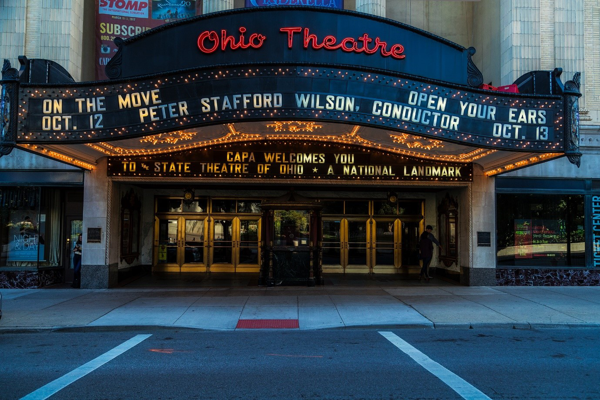

In [3]:
img = Image.open('movies_pic.jpg')
img_resized = img.resize((600, 400))
display(img_resized)

# Microsoft Movie Analysis

**Author:** Bridget Carson
***

# Overview

The movie industry in the U.S.A and Canada was worth 7.37 billion USD in 2022, down from its peak of 11.89 billion USD in 2019 before the COVID pandemic. (https://www.statista.com/statistics/187069/north-american-box-office-gross-revenue-since-1980/)

Microsoft is considering entering the movie production market and is seeking actionable insights into how to make a successful entry.

## Business Problem

Microsoft is looking to enter the movie production industry. Microsoft's main pain points are lack of experience in the movie industry as well as the high competition the business will face. To reduce the risks associated with entering this market, 3 recommendations will be presented based on past movie data for Microsoft to be successful entering the movie industry.

As the main objective of any business venture is financial success, the key target variable is revenue. The most important data analysis questions relate to which factors will maximise the chance of a financially successful entry to the market. 

These questions are important from a business perspective as the commercial viability of any business venture is paramount, and therefore considering factors which will increase movie revenue will help with a successful launch.


## Data Understanding


The data is information relating to movie releases between 2000 and 2019. This is relevant as past movie performance enables Microsoft to understand how successful movies were made. This can assist making decisions for their movie production.

Initially, I focused on the provided datasets for analysis. However, however I found these to be limiting as the TN Movie Budget file (which included budget and release month) did not contain IMDB numbers. This meant merging with other datasets on the movie title, which was not precise as a small difference in puncutation or abbreviations meant that data was missed or counted twice. 

I found a further movie dataset on Kaggle (https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset) which contained IMDB numbers as well as the variables I wanted to include (release month, revenue and budget), and therefore the Kaggle dataset was the basis for analysis. 

The limitation with the Kaggle dataset was the most recent entry was 4th Aug 2017. The TN Movie Budgets file had entries up to 2019. Therefore I merged the merged the titles between these dates into the Kaggle set.

The final dataset includes 3,435 movies including movie name, release date, gross income, production costs, votes. This was then merged with directors and writers for key people analysis.

The target variable is revenue. Although there are websites collecting ratings, businesses require commercial success for new ventures. Further, there is a low correlation (correlation coefficient of 0.21) between worldwide gross revenue and average rating from IMDB. Therefore revenue will be focused on.

I have focused on worldwide revenue as 36% of the movie revenue is from revenue from outside USA & Cananda (based on the TN Movie Budgets data which broke down domestic & worldwide revenue). This is significant enough to include and therefore  worldwide revenue is the target variable.

Using the production budget, I also calculated movie profit. There is a very high correlation (correlation coefficint of 0.98) between the revenue and profit, so either revenue or profit could be used for analysis. Therefore I used worldwide revenue.

With worldwide revenue as the target variable, the analysis focused on finding recommendations which were correlated with higher revenue. The variables which were focused on genre, month of release and recommended director and writer.

***

## Data Preparation


My process for preparing the data was to enable to highest number of movies with the target variables. These were revenue, release month, genre and people. As I focused on worldwide revenue, domestic revenue was dropped.

Data from 6 data sets were used, which required cleaning to enable merging. There was a small number of missing data in the final set in columns for number of votes and average votes, which I filled with the average. For missing values in budget, revenue or genre the rows were dropped, as this information cannot be estimated effectively. 

Having found run time and votes were not positively correlated to revenue, these were later dropped as well.

As Microsoft would be interested in bigger budget productions, movies with revenue or budget below $ 10,000 were dropped.

The final dataset was 3429 movies.

One limitation of the data is that it is right-skewed, due to a large number of movies with small revenue and a smaller number with large revenue. When plotted, there are many movies considered 'outliers'. These were kept as there are a large number, and removing them would take away insights into the highest grossing movies. Further, as Microsoft would have the ability to make large budget movies, the analysis should retain these high grossing movies to gain insights into their success.



## Data Modeling


Once I created the dataset, I used a scatter matrix to look for correlation between variables. The most positively correlated variables were revenue and profit, as well as revenue and budget. There was no significant correlation with run time or average votes.

Looking for the most successful genre required using the explode function to turn the list of genres into rows. The revenue for each genre was then grouped and summed to give a list of genres by revenue. 

Next I filtered on the most successful genres, and grouped the average revenue of key people in the dataset to find the most successful director and writer who had worked in these genres. 

Lastly I used the release month to find the most profitable month to launch movies for these genres. This was done by grouping the average revenue by month. The average revenue was most appropriate as total revenue per month was skewed by the months with the highest number of launches.

Initally I focused on these questions using the provided data, however the limitations of these resulted in 1800 movies to be analysed. Using the dataset from Kaggle meant I could exand the time frame back to 2000 as well as using the IMDB number for more accurate merging. Using this approach increased the dataset to 3429.

Although this is not a large database, these choices were appropriate to address the business problem, as the final dataset contained movies with the variables I wanted to focus on - revenue, release month, genres and people. These became particularly important when the low correlation of run time and average vote became apparent.




In [5]:
#using kaggle dataset as it includes more budget and revenue data as well as release month
#change column header for merge, change release date to date and extract month, change data types to match for merging

kaggle_movies = pd.read_csv(r'zippedData\movies_metadata.csv', dtype='unicode')
kaggle_movies = kaggle_movies.drop(['popularity','spoken_languages','title', 'production_countries', 'id','original_language', 'adult', 'production_companies', 'tagline', 'video'], axis=1)
kaggle_movies.rename(columns={'original_title':'primary_title', 'imdb_id':'tconst', 'revenue':'worldwide_gross'}, inplace=True)
kaggle_movies['release_date'] = pd.to_datetime(kaggle_movies['release_date'], errors='coerce')
kaggle_movies['release_year'] = kaggle_movies['release_date'].dt.year
kaggle_movies['release_month'] = kaggle_movies['release_date'].dt.month
kaggle_movies = kaggle_movies.drop(kaggle_movies[(kaggle_movies['budget'].str.len()>12)].index)
kaggle_movies['budget'] = kaggle_movies['budget'].astype(float)
kaggle_movies['worldwide_gross'] = kaggle_movies['worldwide_gross'].astype(float)
kaggle_movies['runtime'] = kaggle_movies['runtime'].astype(float)
kaggle_movies['vote_average'] = kaggle_movies['vote_average'].astype(float)
kaggle_movies['vote_count'] = kaggle_movies['vote_count'].astype(float)

#fill empty runtimes with average runtime
kaggle_movies['runtime'] = kaggle_movies['runtime'].fillna(kaggle_movies['runtime'].mean())

#filter for data after 2000, remove rows where revenue or budget are $0, drop rows with nan, check most recent date
kaggle_movies = kaggle_movies[kaggle_movies.release_year>2000]
kaggle_movies = kaggle_movies[kaggle_movies.budget !=0.00]
kaggle_movies = kaggle_movies[kaggle_movies.worldwide_gross !=0.00]
kaggle_movies = kaggle_movies.dropna()

#changing genres from dictionary to list to be able to merge with genres in TN Movie Budget data
kaggle_movies['genres'] = kaggle_movies['genres'].str.replace('[','')
kaggle_movies['genres'] = kaggle_movies['genres'].str.replace('{', '')
kaggle_movies['genres'] = kaggle_movies['genres'].str.replace("'id'", '')
kaggle_movies['genres'] = kaggle_movies['genres'].str.replace(":", '')
kaggle_movies['genres'] = kaggle_movies['genres'].str.replace("'name'", '')
kaggle_movies['genres'] = kaggle_movies['genres'].str.replace("}", '')
kaggle_movies['genres'] = kaggle_movies['genres'].str.replace("]", '')
kaggle_movies['genres'] = kaggle_movies['genres'].str.replace("'", '')
kaggle_movies['genres'] = kaggle_movies['genres'].str.replace(' ', '')
kaggle_movies['genres'] = kaggle_movies['genres'].replace('(\d+),', '', regex=True)
kaggle_movies['genres'] = kaggle_movies['genres'].str.split(",", n=6, expand=False)


print(kaggle_movies['release_date'].max())
#kaggle_movies.info()

2017-08-04 00:00:00


C:\Users\bridg\AppData\Local\Temp\ipykernel_13104\4097848150.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  kaggle_movies['release_date'] = pd.to_datetime(kaggle_movies['release_date'], errors='coerce')


In [7]:
kaggle_movies.head()

,budget,genres,tconst,primary_title,release_date,worldwide_gross,runtime,vote_average,vote_count,release_year,release_month
3926,30000000.0,"[Action, Crime, Drama]",tt0218817,Antitrust,2001-01-12,18195610.0,108.0,5.8,156.0,2001.0,1.0
3928,13000000.0,"[Drama, Family, Romance, Music]",tt0206275,Save the Last Dance,2001-01-12,91038276.0,112.0,6.3,359.0,2001.0,1.0
3930,35000000.0,"[Crime, Drama, Mystery, Thriller]",tt0237572,The Pledge,2001-01-09,29400000.0,123.0,6.6,221.0,2001.0,1.0
3942,11000000.0,"[Crime, Comedy]",tt0186589,Sugar & Spice,2001-01-24,13276953.0,81.0,5.7,60.0,2001.0,1.0
3943,35000000.0,[Comedy],tt0209475,The Wedding Planner,2001-01-26,94728529.0,103.0,5.4,433.0,2001.0,1.0


In [5]:
#kaggle_movies.

In [8]:
#loading TN Movie Budget dataset for more recent movies, cleaning to enable merge with kaggle dataset

dftnmovie_budget = pd.read_csv(r'zippedData\tn.movie_budgets.csv.gz')

#change column header for merge, change release date to date and extract month
dftnmovie_budget.rename(columns={'movie':'primary_title', 'production_budget':'budget'}, inplace=True)
dftnmovie_budget['release_date'] = pd.to_datetime(dftnmovie_budget['release_date'])
dftnmovie_budget['release_month'] = dftnmovie_budget['release_date'].dt.month
#remove special characters
dftnmovie_budget['primary_title'] = dftnmovie_budget['primary_title'].str.replace('â', "'")
dftnmovie_budget['primary_title'] = dftnmovie_budget['primary_title'].str.replace('â', " - ")
dftnmovie_budget['primary_title'] = dftnmovie_budget['primary_title'].str.replace('PokÃ©mon', "Pokemon")

#titles left with special chars are all foreign language
#print(dftnmovie_budget[dftnmovie_budget['primary_title'].str.contains('Ã|¢|Â|€|Â|™')])

#change budget and revenue to float, remove $0 rows
dftnmovie_budget['budget'] = dftnmovie_budget['budget'].str.replace('$', '')
dftnmovie_budget['budget'] = dftnmovie_budget['budget'].str.replace(',', '')
dftnmovie_budget['budget'] = dftnmovie_budget['budget'].astype('float')
dftnmovie_budget = dftnmovie_budget[dftnmovie_budget.budget !=0.00]
dftnmovie_budget['worldwide_gross'] = dftnmovie_budget['worldwide_gross'].str.replace('$', '')
dftnmovie_budget['worldwide_gross'] = dftnmovie_budget['worldwide_gross'].str.replace(',', '')
dftnmovie_budget['worldwide_gross'] = dftnmovie_budget['worldwide_gross'].astype('float')
dftnmovie_budget = dftnmovie_budget[dftnmovie_budget.worldwide_gross !=0.00]
dftnmovie_budget['domestic_gross'] = dftnmovie_budget['domestic_gross'].str.replace('$', '')
dftnmovie_budget['domestic_gross'] = dftnmovie_budget['domestic_gross'].str.replace(',', '')
dftnmovie_budget['domestic_gross'] = dftnmovie_budget['domestic_gross'].astype('float')
dftnmovie_budget = dftnmovie_budget[dftnmovie_budget.domestic_gross !=0.00]


#finding % of worldwide revenue compared to domestic revenue
pc_worldwide = ((dftnmovie_budget['worldwide_gross']-dftnmovie_budget['domestic_gross'])/dftnmovie_budget['worldwide_gross']).mean().round(2)*100
print("Worldwide revenue is " + str(pc_worldwide) + "%")

#remove rows prior to 2017-08-04, the last date in kaggle data
dftnmovie_budget = dftnmovie_budget.loc[(dftnmovie_budget['release_date'] > '2017-08-04') ]

#dftnmovie_budget.info()


Worldwide revenue is 36.0%


In [9]:
df_movieinfo = pd.read_csv(r'zippedData\imdb.title.basics.csv.gz')
df_movieinfo['primary_title'] = df_movieinfo['primary_title'].str.replace('Pokémon', 'Pokemon')
dfimdb_rating = pd.read_csv(r'zippedData\imdb.title.ratings.csv.gz')

#merging TN Movie Budget and Movie Info datasets to add tconst for merge with kaggle

combined_df7 = dftnmovie_budget.merge(df_movieinfo, on='primary_title', how='inner')
combined_df7 = combined_df7.drop(['id', 'domestic_gross', 'original_title'], axis=1)
combined_df7['runtime_minutes'] = combined_df7['runtime_minutes'].fillna(combined_df7['runtime_minutes'].mean())
combined_df7['genres'] = combined_df7['genres'].str.split(",", n=6, expand=False)

combined_df7.dropna(inplace=True)

In [10]:
#merge with IMDB rating to add ratings info
combined_df8 = combined_df7.merge(dfimdb_rating, on='tconst', how='inner')
combined_df8.rename(columns={'start_year': 'release_year', 'runtime_minutes': 'runtime', 'averagerating': 'vote_average', 'numvotes':'vote_count'}, inplace=True)
combined_df8 = combined_df8.drop_duplicates(subset=['primary_title'], keep='first')


In [11]:
#concatenate kaggle movies and imdb datasets

frames = [kaggle_movies, combined_df8]
combined_df9 = pd.concat(frames)
combined_df9['release_year'] = combined_df9['release_year'].astype('int64')
combined_df9['profit'] = combined_df9['worldwide_gross'] - combined_df9['budget']
combined_df9['profit_margin'] = combined_df9['profit']/combined_df9['worldwide_gross']
combined_df9['profit_margin'] = combined_df9['profit_margin'].round(2)
combined_df9 = combined_df9.drop_duplicates(subset=['tconst'], keep='first')


In [12]:
#check how many titles have revenue or budget less than $10,000 - being a very small production or possibly a typo or missing number
print(len(combined_df9.loc[combined_df9['worldwide_gross'] < 10000]))
print(len(combined_df9.loc[combined_df9['budget'] < 10000]))

55
29


In [13]:
#removal of titles with revenue or budget less than $10,000 
combined_df9 = combined_df9.loc[(combined_df9['worldwide_gross'] > 10000) ]
combined_df9 = combined_df9.loc[(combined_df9['budget'] > 10000) ]
combined_df9.info()

#giving final dataset of 3429

<class 'pandas.core.frame.DataFrame'>
Index: 3429 entries, 3926 to 256
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   budget           3429 non-null   float64       
 1   genres           3429 non-null   object        
 2   tconst           3429 non-null   object        
 3   primary_title    3429 non-null   object        
 4   release_date     3429 non-null   datetime64[ns]
 5   worldwide_gross  3429 non-null   float64       
 6   runtime          3429 non-null   float64       
 7   vote_average     3429 non-null   float64       
 8   vote_count       3429 non-null   float64       
 9   release_year     3429 non-null   int64         
 10  release_month    3429 non-null   float64       
 11  profit           3429 non-null   float64       
 12  profit_margin    3429 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(3)
memory usage: 375.0+ KB


In [14]:
combined_df9.describe()

,budget,release_date,worldwide_gross,runtime,vote_average,vote_count,release_year,release_month,profit,profit_margin
count,3.429000e+03,3429,3.429000e+03,3429.000000,3429.000000,3429.000000,3429.000000,3429.000000,3.429000e+03,3429.000000
mean,3.950662e+07,2010-04-17 08:43:15.275590656,1.142545e+08,109.599046,6.231963,5334.223389,2009.737241,6.790610,7.474792e+07,-6.468938
min,1.117800e+04,2001-01-09 00:00:00,1.001800e+04,0.000000,1.000000,1.000000,2001.000000,1.000000,-2.002376e+08,-1942.820000
25%,8.000000e+06,2006-05-19 00:00:00,9.455232e+06,96.000000,5.700000,127.000000,2006.000000,4.000000,-1.833000e+06,-0.250000
50%,2.200000e+07,2010-06-18 00:00:00,4.163726e+07,106.000000,6.300000,423.000000,2010.000000,7.000000,1.531227e+07,0.490000
75%,5.000000e+07,2014-05-16 00:00:00,1.219750e+08,120.000000,6.800000,1293.000000,2014.000000,10.000000,7.762872e+07,0.740000
max,3.800000e+08,2019-06-07 00:00:00,2.787965e+09,338.000000,9.000000,670926.000000,2019.000000,12.000000,2.550965e+09,1.000000
std,4.748739e+07,NaN,2.010125e+08,20.880820,0.868228,31032.255465,4.839557,3.415493,1.679519e+08,58.444074


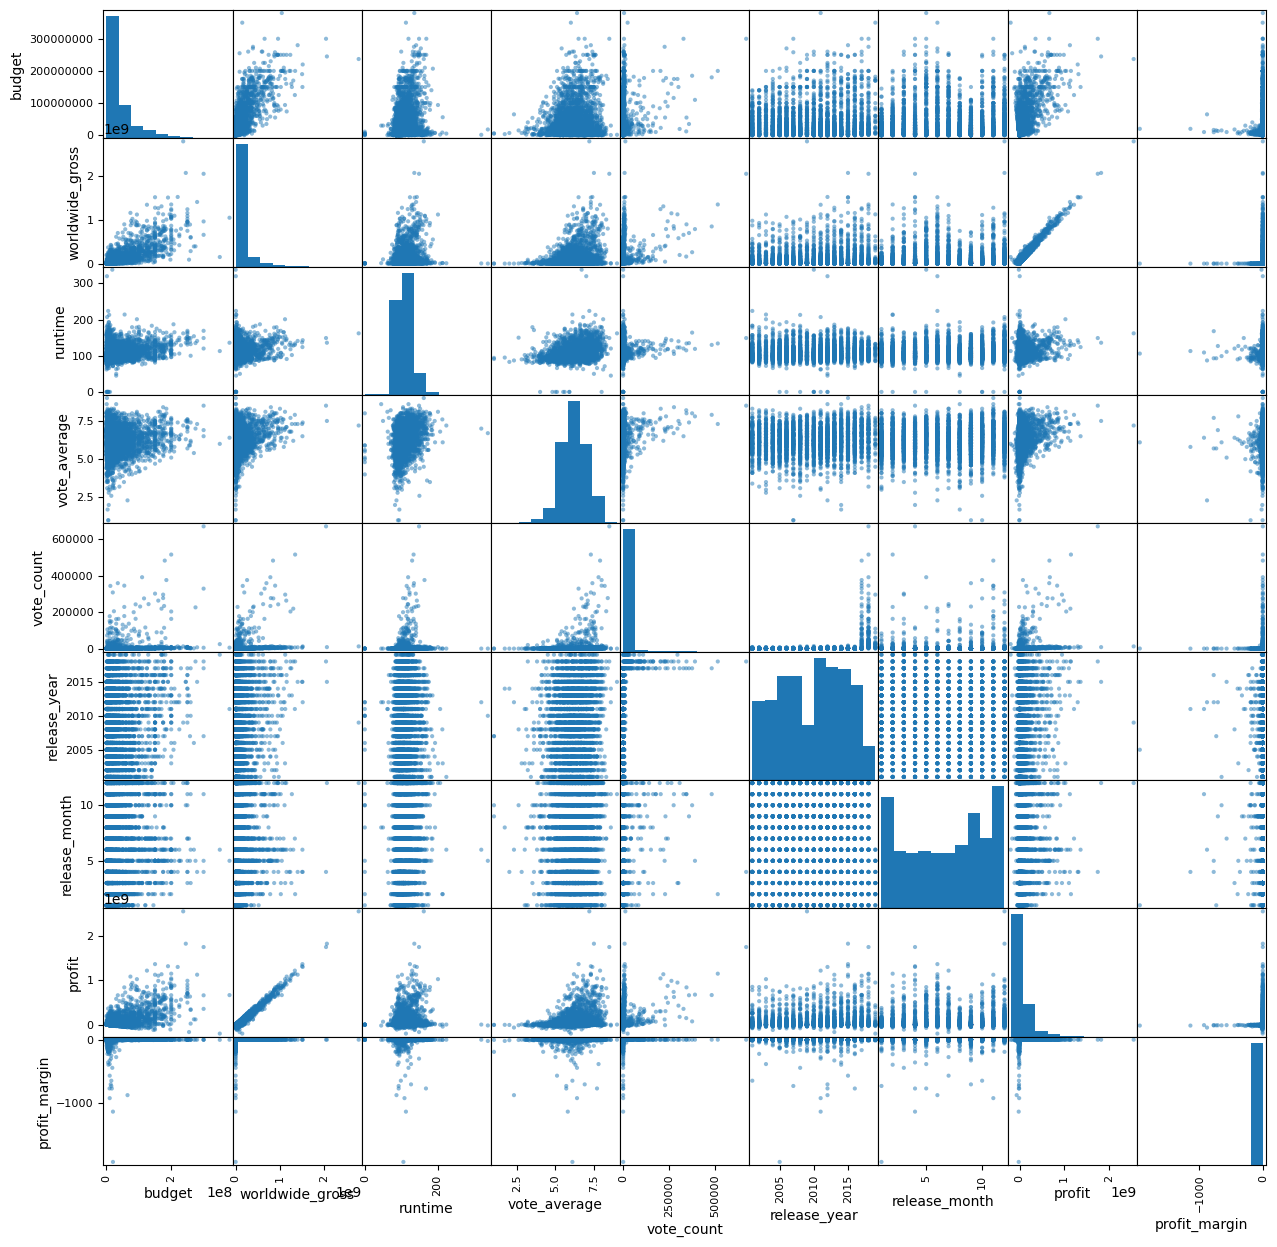

In [15]:
pd.plotting.scatter_matrix(combined_df9, figsize=(15,15));

In [16]:
#To start analysis, looking whether revenue or profit is the best variable
#As below, correlation coefficient of 0.98 is almost perfect correlation between worldwide_gross & profit 
#therefore you could use either measure - we will stay with worldwide_gross
combined_df9['worldwide_gross'].corr(combined_df9['profit'])

0.9827898596653226

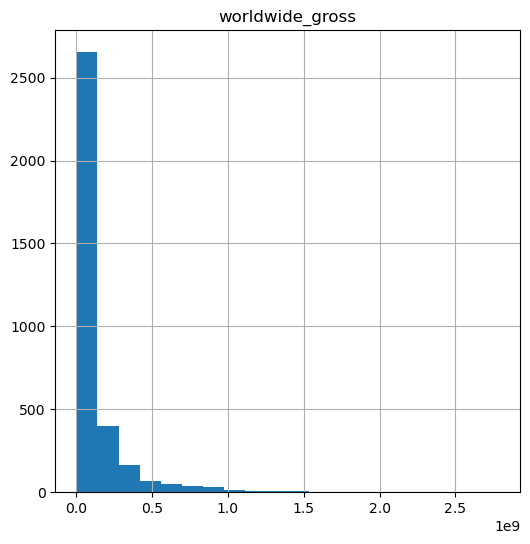

In [17]:
#checking the main variable data - looking at revenue in a histogram, the data is skewed to the right. 
#There are many films with a small amount of revenue and a smaller amount with large revenue
#This is a limitation of the dataset as it is not normally distributed. 
combined_df9.hist(column='worldwide_gross', bins=20)
plt.show()

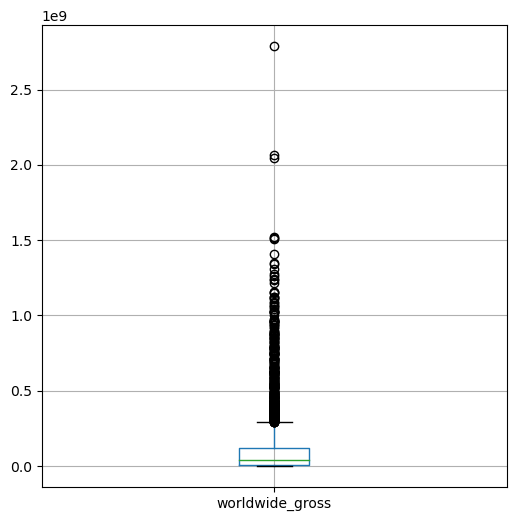

In [18]:
# using boxplot for revenue, there are many 'outliers' in the data above the IQR 
# There are too many outliers to remove these high revenue values. 
#Further, Miscrosoft would be interested in these successful films when analysing how to create their own successful movies
#Therefore these high outliers will be retained. 
#Movies with revenue or budget below $10,000 have already been removed
combined_df9.boxplot('worldwide_gross')
plt.show()

In [19]:
#looking at the matrix above, revenue & budget look to have a positively corrleated releationship 
# As below, correlation coefficient is high 0.76
#therefore, the higher the budget the higher the revenue
combined_df9['worldwide_gross'].corr(combined_df9['budget'])

0.7570674973669298

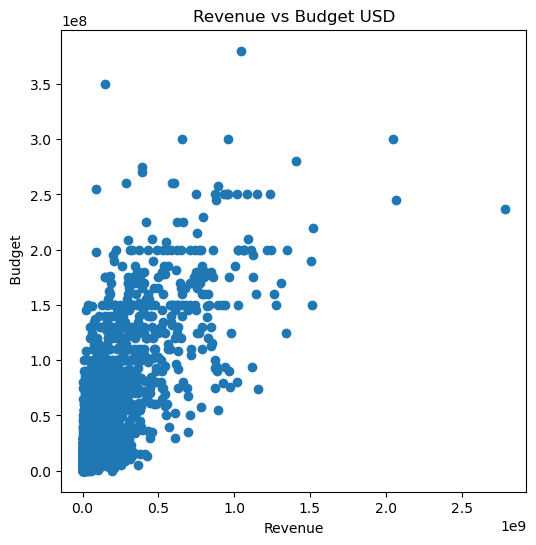

In [20]:
x = combined_df9['worldwide_gross']
y = combined_df9['budget']
fig, ax = plt.subplots()
plt.scatter(x, y)
b,a = np.polyfit(x, y, deg=1)
plt.xlabel('Revenue')
plt.ylabel(" Budget")
plt.title('Revenue vs Budget USD')
plt.show()

In [21]:
#low correlation coefficient between revenue and movie run time
combined_df9['worldwide_gross'].corr(combined_df9['runtime'])

0.21615750065622685

In [22]:
#low correlation coefficient between revenue and average vote
combined_df9['worldwide_gross'].corr(combined_df9['vote_average'])

0.21641384878756567

In [23]:
#low correlation coefficient between revenue and number of votes
combined_df9['worldwide_gross'].corr(combined_df9['vote_count'])

0.312106106759245

In [24]:
#Looking for most profitable genre
#As titles can have mulitple genres, use explode() to create a separate column for each genre, replace duplicates for Science Fiction
#This means the revenue for a movie with multiple titles are counted more than once, however the initial dataset 
#contained too many variations to compare the original list
df_genres = combined_df9.explode('genres')
df_genres = df_genres.drop(['budget','tconst','primary_title', 'release_date', 'runtime','vote_average', 'vote_count', 'release_year', 'release_month', 'profit','profit_margin'], axis=1)
df_genres = df_genres.replace('Sci-Fi', 'ScienceFiction')
df_genres = df_genres.replace('ScienceFiction,Family', 'ScienceFiction')
print(df_genres['genres'].unique())


['Action' 'Crime' 'Drama' 'Family' 'Romance' 'Music' 'Mystery' 'Thriller'
 'Comedy' 'Horror' 'ScienceFiction' 'Animation' 'Adventure' 'Fantasy'
 'War' 'History' '' 'Western' 'Documentary' 'Foreign' 'Biography'
 'Musical' 'Sport']


In [25]:
#group total revenue by genre
genre_revenue = df_genres.groupby('genres').sum().sort_values('worldwide_gross', ascending=False)
print(genre_revenue)

                worldwide_gross
genres                         
Adventure          1.790719e+11
Action             1.733830e+11
Comedy             1.219895e+11
Drama              1.048024e+11
Thriller           9.068407e+10
Fantasy            8.929523e+10
Family             8.581103e+10
ScienceFiction     8.472467e+10
Animation          5.970624e+10
Romance            4.404453e+10
Crime              4.062783e+10
Mystery            2.432996e+10
Horror             2.313935e+10
History            1.045588e+10
War                9.810445e+09
Music              9.474200e+09
Biography          3.150025e+09
Western            2.804350e+09
Documentary        2.050634e+09
Musical            3.866656e+08
Sport              2.601187e+08
                   1.450072e+08
Foreign            1.097827e+08


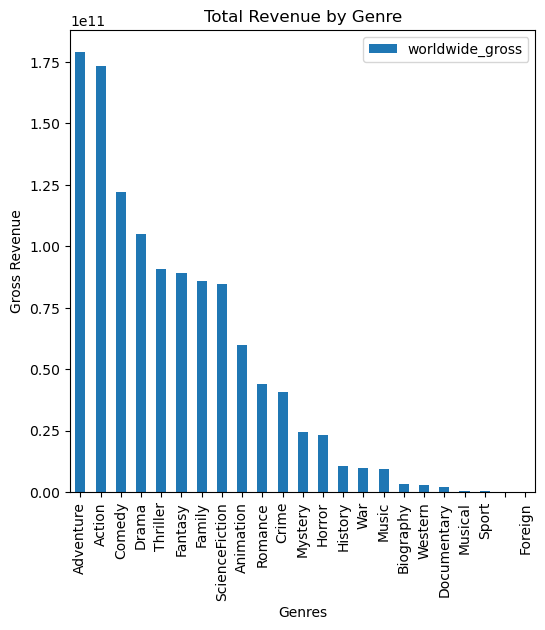

In [26]:
#Graph the above
#The below graph shows Adventure and Action movies are the most financially successful genres
#These genres are significantly higher than the other genres
genre_revenue.plot.bar()
plt.xlabel('Genres')
plt.ylabel('Gross Revenue')
plt.title('Total Revenue by Genre')
plt.show()

In [27]:
#add in datasets to include key people to find most successful people to hire in top genres

dfimdb_name_basics = pd.read_csv(r'zippedData\imdb.name.basics.csv.gz')
dfimdb_name_basics.head()

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [28]:
dfimdbtitle_principals = pd.read_csv(r'zippedData\imdb.title.principals.csv.gz')
dfimdbtitle_principals.head()

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


In [29]:
names = dfimdbtitle_principals.merge(dfimdb_name_basics, on='nconst', how='inner')
names.head()

,tconst,ordering,nconst,category,job,characters,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]",Tommy Dysart,NaN,NaN,actor,"tt0093120,tt0076974,tt0084296,tt0077064"
1,tt0111414,2,nm0398271,director,NaN,NaN,Frank Howson,1952.0,NaN,"actor,writer,producer","tt0104271,tt0094789,tt0102076,tt0111414"
2,tt5573596,5,nm0398271,director,NaN,NaN,Frank Howson,1952.0,NaN,"actor,writer,producer","tt0104271,tt0094789,tt0102076,tt0111414"
3,tt0111414,3,nm3739909,producer,producer,NaN,Barry Porter-Robinson,NaN,NaN,"producer,art_department","tt0290884,tt0101374,tt0111414,tt1566940"
4,tt0323808,10,nm0059247,editor,NaN,NaN,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director","tt0402910,tt1022883,tt0086190,tt0490181"


In [30]:
#combining key people data with initial dataset and clean up
combined_df2 = combined_df9.merge(names, on='tconst')
#removing deceased people
combined_df2 = combined_df2[pd.isnull(combined_df2['death_year'])]
#removing columns & duplicates
combined_df2 = combined_df2.drop(['primary_profession', 'known_for_titles', 'ordering', 'nconst', 'runtime', 'vote_average','vote_count' ,'death_year', 'birth_year', 'job', 'characters','primary_profession', 'known_for_titles'], axis=1)
combined_df2 = combined_df2.drop_duplicates(subset=['tconst'], keep='first')
#explode genres list into separate rows
df_ppl_genres = combined_df2.explode('genres')

df_ppl_genres.head()

,budget,genres,tconst,primary_title,release_date,worldwide_gross,release_year,release_month,profit,profit_margin,category,primary_name
0,3512454.0,Drama,tt2018086,Camille Claudel 1915,2013-03-13,115860.0,2013,3.0,-3396594.0,-29.32,director,Bruno Dumont
10,40000000.0,Adventure,tt1701210,Black Gold,2011-12-21,5446000.0,2011,12.0,-34554000.0,-6.34,actor,Mark Strong
10,40000000.0,Drama,tt1701210,Black Gold,2011-12-21,5446000.0,2011,12.0,-34554000.0,-6.34,actor,Mark Strong
20,19000000.0,Romance,tt1216492,Leap Year,2010-01-08,29922472.0,2010,1.0,10922472.0,0.37,producer,Roger Birnbaum
20,19000000.0,Comedy,tt1216492,Leap Year,2010-01-08,29922472.0,2010,1.0,10922472.0,0.37,producer,Roger Birnbaum


In [31]:
#Revenue & budget correlation coefficient is high 0.76
#therefore, the higher the budget the higher the revenue
print(combined_df9['worldwide_gross'].corr(combined_df9['budget']))

0.7570674973669298


In [32]:
#Due to Microsoft's lack of experience in movies, they should hire the most successful people in these genres for their expertise
#As above, budget is positively correlated to revenue, therefore Microsoft should invest in the most successful key people in these genres

#filtering to key people in Adventure genre as highest grossing genre
adventure_ppl = df_ppl_genres[df_ppl_genres['genres'].str.contains('Adventure')]

#Top grossing writer in adventure movies
adventure_writer = adventure_ppl[adventure_ppl['category']=='writer']
top_adventure_writer = adventure_writer.groupby(['primary_name'])['worldwide_gross'].mean().sort_values(ascending=False).head(1)
print(top_adventure_writer)

#Top grossing director in adventure movies
adv_director = adventure_ppl[adventure_ppl['category']=='director']
top_adventure_director = adv_director.groupby(['primary_name'])['worldwide_gross'].mean().sort_values(ascending=False).head(1)
print(top_adventure_director)

primary_name
Nicole Perlman    1.123062e+09
Name: worldwide_gross, dtype: float64
primary_name
Rich Moore    1.023784e+09
Name: worldwide_gross, dtype: float64


In [33]:
#filtering to key people in Action genre as second highest grossing genre

#filtering to top grossing writer in action movies
action_ppl = df_ppl_genres[df_ppl_genres['genres'].str.contains('Action')]
action_writer = action_ppl[action_ppl['category']=='writer']
top_action_writer = action_writer.groupby(['primary_name'])['worldwide_gross'].mean().sort_values(ascending=False).head(1)
print(top_action_writer)

#filtering to top grossing director in action movies
action_director = action_ppl[action_ppl['category']=='director']
top_action_director = action_director.groupby(['primary_name'])['worldwide_gross'].mean().sort_values(ascending=False).head(1)
print(top_action_director)

primary_name
Nicole Perlman    1.123062e+09
Name: worldwide_gross, dtype: float64
primary_name
Clint Eastwood    542307423.0
Name: worldwide_gross, dtype: float64


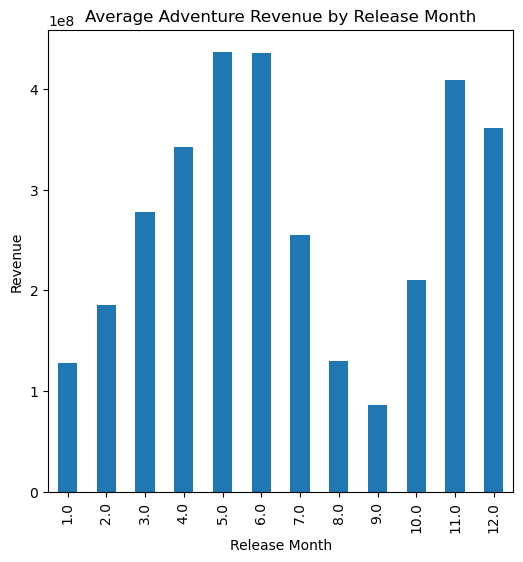

In [34]:
#Grouping average revenue per movie with release month to find the best month to release Adventure and Action movies
#The below graphs show May/June and Nov/Dec are the best periods of the year for maximum financial success for Adventure & Action movies

df_genres_months = combined_df9.explode('genres')
df_adventure_months = df_genres_months[df_genres_months['genres'].str.contains('Adventure')]
df_adventure_months_mean = df_adventure_months.groupby('release_month')['worldwide_gross'].mean()
df_adventure_months_mean.plot.bar()
plt.xlabel('Release Month')
plt.ylabel('Revenue')
plt.title('Average Adventure Revenue by Release Month')
plt.show()

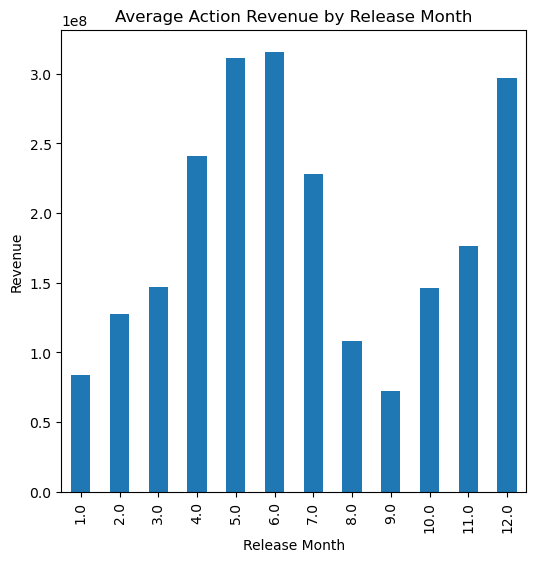

In [35]:
df_action_months = df_genres_months[df_genres_months['genres'].str.contains('Action')]
df_action_months_mean = df_action_months.groupby('release_month')['worldwide_gross'].mean()
df_action_months_mean.plot.bar()
plt.xlabel('Release Month')
plt.ylabel('Revenue')
plt.title('Average Action Revenue by Release Month')
plt.show()

## Evaluation


From the data there are actionable insights for Microsoft to enable a successful launch into the movie production industry.

Genre is one movie element where there is a large disparaty in revenue results. Adventure and Action films achieved the highest revenue results. Given that many movies are considered both Action and Adventure, this result could be from the same movies being counted in both these genres. However, there is a clear advantage on focusing on these genres for financial success.

Knowing the most successful genres, Microsoft can hire the most successful key people in these genres. This is recommended due to Microsoft not having movie production experience, the expertise of these successful people could be utilised. These people will be expensive, but as there is a high correlation between revenue and budget, investing in these people and a high budget for the movie overall would increase the probability of financial success.

Release month is a variable where there are clear months favouring higher revenue. Timing for movie release for the US summer and the Christmas period would increase the chance of movie success for ,ovies in the Adventure and Action genres. This result could be skewed due to production companies releasing their blockbusters at these popular times, so further information might be needed.



## Conclusions


From these results, I would recommend the following to Microsoft - 

1 - Focus on movies in the Adventure and/or Action genres. Movies in these genres are significantly more financially successful than other genres.

2 - Hire the most successful key people from Adventure or Action movies. The most successful writer in both Adventure and Action is Nicole Perlman. The most successful director in Adventure is Rich Moore and in Action it is Clint Eastwood. 

3 - Aim to release movies coinciding with the US summer period (May/June) or the Christmas period (Nov/Dec) as these are the most financial success times for Adventure and Action movies. 

While these recommendations will improve the likelihood of financial success, there will be huge competition in this business venture and require the raising of large amounts of funds for covering production budgets. Further, some of the most successful movies in recent time are franchises (e.g. Marvel), which Microsoft does not own. 

This was a small dataset and therefore further information would be helpful to create a larger dataset with the required variables to continue analysing the movie industry. 


